## Importing dataset and visualization

In [8]:
import PRF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath('../../'))
from utils import load_keel_dataset

file_path="../keel_data/iris.dat"


X_train, X_test, y_train, y_test, label_map = load_keel_dataset(
    train_path=file_path, # Path to the WHOLE dataset (if it's not already split)
    already_split=False  # Performs the train_test split if False
) 
print("Head of training data: \n", X_train[:5])
print("Head of labels: \n", y_train[:5])

Head of training data: 
 [[5.4 3.7 1.5 0.2]
 [4.9 2.5 4.5 1.7]
 [5.5 2.4 3.8 1.1]
 [4.8 3.4 1.6 0.2]
 [5.6 2.7 4.2 1.3]]
Head of labels: 
 [1 3 2 1 2]


In [9]:
from utils import add_label_noise

y_train_noisy, _, probs_y, _ = add_label_noise(y_train, apply_to_test=False, noise_level=0.2, mode="proportion")

save_dir = "../../data/noisy_label_datasets/"
os.makedirs(save_dir, exist_ok=True)

# Save training features and noisy labels + noise probabilities
np.save(os.path.join(save_dir, "X_train_iris20.npy"), X_train)
np.save(os.path.join(save_dir, "y_train_noisy_iris20.npy"), y_train_noisy)
np.save(os.path.join(save_dir, "y_uncertainty_iris20.npy"), probs_y)

# Save test features and labels
np.save(os.path.join(save_dir, "X_test_iris20.npy"), X_test)
np.save(os.path.join(save_dir, "y_test_iris20.npy"), y_test)

y_train_noisy = np.load(os.path.join(save_dir, "y_train_noisy_iris20.npy"))
print("Pure labels): \n", y_train[:20])
print("Noisy labels: \n", y_train_noisy[:20])

Pure labels): 
 [1 3 2 1 2 3 2 3 3 3 3 2 2 2 2 1 1 3 3 1]
Noisy labels: 
 [1 3 2 1 2 3 1 3 3 1 3 2 3 2 2 1 1 3 3 1]


#### Visualization

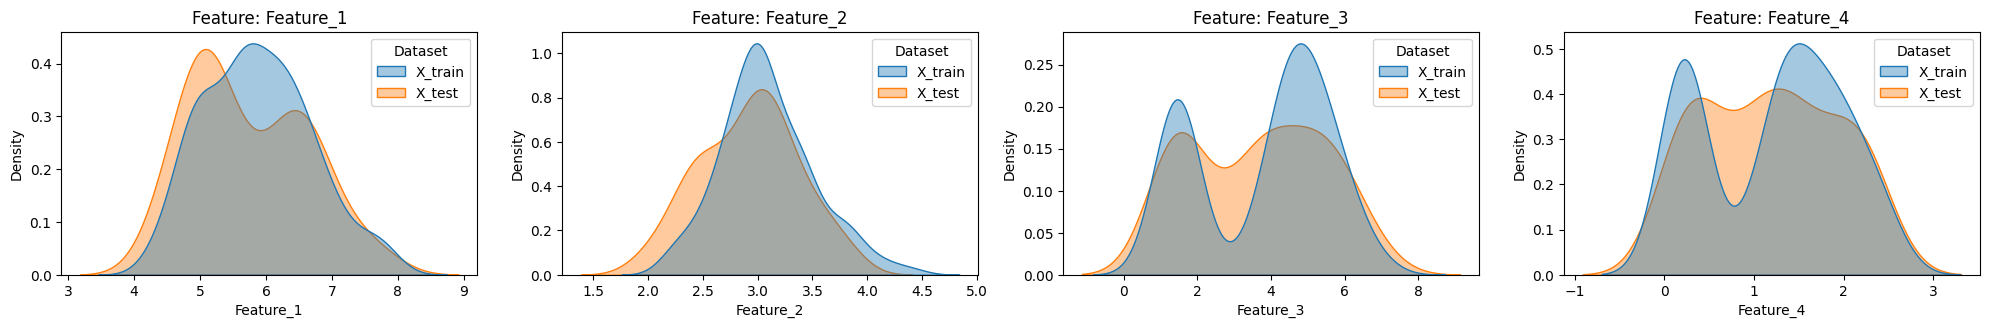

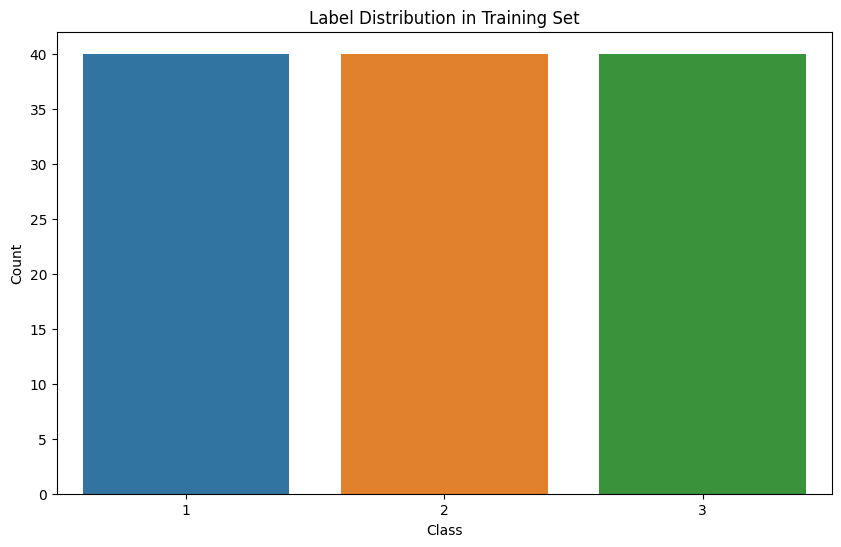

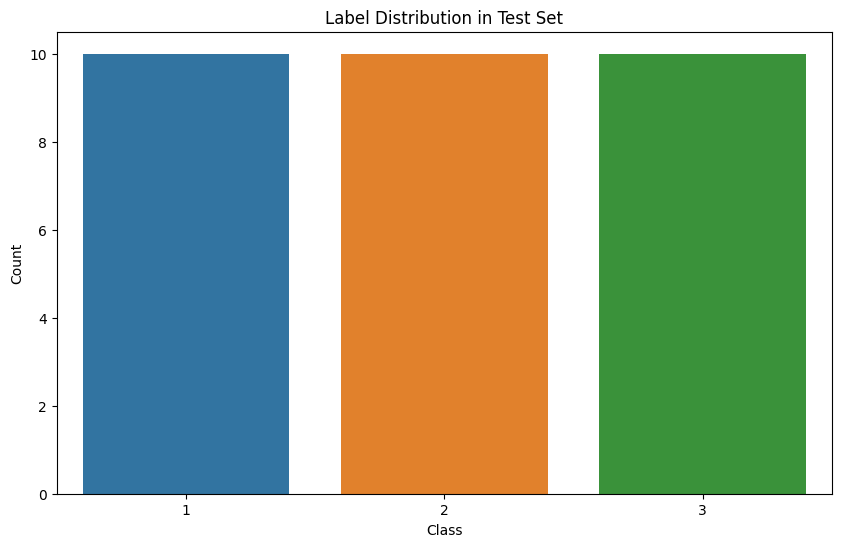

In [8]:
feature_names_train = [f'Feature_{i+1}' for i in range(X_train.shape[1])]

df1 = pd.DataFrame(X_train, columns=feature_names_train)
df1['Label'] = y_train
df1['Dataset'] = 'X_train'

feature_names_test = [f'Feature_{i+1}' for i in range(X_test.shape[1])]

df2 = pd.DataFrame(X_test, columns=feature_names_test)
df2['Label'] = y_test       # <-- Fix here: assign y_test to df2, not df1
df2['Dataset'] = 'X_test'

# Combine both train and test dataframes for plotting
df_all = pd.concat([df1, df2], ignore_index=True)

# Plot distributions of each feature side by side
plt.figure(figsize=(20, 15))
for i, feature in enumerate(feature_names_train):
    plt.subplot(5, 4, i + 1)
    sns.kdeplot(data=df_all, x=feature, hue='Dataset', common_norm=False, fill=True, alpha=0.4, bw_adjust=0.9)
    plt.title(f"Feature: {feature}")
plt.tight_layout()
plt.show()



# Plot label distribution (only for training set or combined if you want)
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=df1, order=sorted(df1['Label'].unique()))
plt.title("Label Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=df2, order=sorted(df2['Label'].unique()))
plt.title("Label Distribution in Test Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


#### PDRF

In [9]:
# TODO: Use the PDRF algorithm

accuracy_PDRF = 1.0 # Placeholder for the actual accuracy 

## Other methods for classification

#### Probabilistic Random Forest

In [10]:
n_trees = 10
prf_cls = PRF.prf(n_estimators=n_trees,  bootstrap=True)
prf_cls.fit(X=X_train, y=y_train)
score = prf_cls.score(X_test, y=y_test)
print('PRF Score: ', score)

#Score is defined like this, so same as accuracy

'''def score(self, X, y, dX=None):
        y_pred = self.predict(X, dX)
        score = (y_pred == (y)).sum()/len(y)
        return score''' 

accuracy_PRF = score

PRF Score:  0.9666666666666667


#### Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(n_estimators=20, random_state=27)
# Fit the model
rf.fit(X_train, y_train)

# Predict on test data
y_pred = rf.predict(X_test)

accuracy_RF = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_RF:.4f}")

Accuracy: 0.9667


#### Deep Forest

In [12]:
from deepforest import CascadeForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Set random_state for reproducibility
clf = CascadeForestClassifier(n_estimators=2, random_state=27)  # 2 estimators per layer by default

# Fit the model
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
accuracy_DF = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_DF:.4f}")
print(classification_report(y_test, y_pred))

[2025-06-03 10:36:42.903] Start to fit the model:
[2025-06-03 10:36:42.903] Fitting cascade layer = 0 


[2025-06-03 10:36:43.199] layer = 0  | Val Acc = 94.167 % | Elapsed = 0.296 s
[2025-06-03 10:36:43.199] Fitting cascade layer = 1 
[2025-06-03 10:36:43.449] layer = 1  | Val Acc = 92.500 % | Elapsed = 0.250 s
[2025-06-03 10:36:43.449] Early stopping counter: 1 out of 2
[2025-06-03 10:36:43.450] Fitting cascade layer = 2 
[2025-06-03 10:36:43.685] layer = 2  | Val Acc = 95.000 % | Elapsed = 0.235 s
[2025-06-03 10:36:43.686] Fitting cascade layer = 3 
[2025-06-03 10:36:43.885] layer = 3  | Val Acc = 93.333 % | Elapsed = 0.199 s
[2025-06-03 10:36:43.885] Early stopping counter: 1 out of 2
[2025-06-03 10:36:43.885] Fitting cascade layer = 4 
[2025-06-03 10:36:44.093] layer = 4  | Val Acc = 93.333 % | Elapsed = 0.208 s
[2025-06-03 10:36:44.094] Early stopping counter: 2 out of 2
[2025-06-03 10:36:44.094] Handling early stopping
[2025-06-03 10:36:44.094] The optimal number of layers: 3
[2025-06-03 10:36:44.095] Start to evalute the model:
[2025-06-03 10:36:44.095] Evaluating cascade layer = 

#### Neural Network

In [13]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import os

# Disable GPU (otherwise my PC explodes for some reason)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
np.random.seed(27)
tf.random.set_seed(27)

# Detect classification type
unique_classes = np.unique(y_train)
num_classes = len(unique_classes)
is_binary = num_classes == 2

# One-hot encode labels if multiclass
if not is_binary:
    y_train_cat = to_categorical(np.searchsorted(unique_classes, y_train))
    y_test_cat = to_categorical(np.searchsorted(unique_classes, y_test))
else:
    y_train_cat = y_train
    y_test_cat = y_test

# Define the model builder function
def create_model(hidden_units=32, dropout_rate=0.5, optimizer='adam'):
    model = Sequential()
    model.add(Dense(hidden_units, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(dropout_rate))
    if is_binary:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    else:
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap with SciKeras
model = KerasClassifier(model=create_model, verbose=0)

# Grid search parameters
param_grid = {
    'model__hidden_units': [32, 64],
    'model__dropout_rate': [0.3, 0.5],
    'model__optimizer': ['adam'],
    'batch_size': [16],
    'epochs': [20]
}

# Grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=1)
grid_result = grid.fit(X_train, y_train_cat)

# Evaluate the best model
best_model = grid_result.best_estimator_

if is_binary:
    y_pred = best_model.predict(X_test)
    y_test_true = y_test
else:
    y_pred_proba = best_model.predict_proba(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_test_true = np.searchsorted(unique_classes, y_test)

# Output results
accuracy_NN = accuracy_score(y_test_true, y_pred)
print("Best params:", grid_result.best_params_)
print(f"Accuracy: {accuracy_NN:.4f}")
print(classification_report(y_test_true, y_pred, digits=4))


2025-06-03 12:36:44.129373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-03 12:36:44.305280: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-03 12:36:44.318123: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/gurobi1102/win64/lib:/usr/local/gurobi1102/win64/lib
2025-06-03 12:36:44.318158: I

Best params: {'batch_size': 16, 'epochs': 20, 'model__dropout_rate': 0.3, 'model__hidden_units': 64, 'model__optimizer': 'adam'}
Accuracy: 0.9333
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        10
           1     1.0000    0.8000    0.8889        10
           2     0.8333    1.0000    0.9091        10

    accuracy                         0.9333        30
   macro avg     0.9444    0.9333    0.9327        30
weighted avg     0.9444    0.9333    0.9327        30



#### Bayesian Logistic Regression (??)

#### Kernel SVM

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# 1. Define the model
svm_model = SVC()

# 2. Define hyperparameter grid
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.01, 0.1, 1, 10],
    'gamma': ['scale', 'auto']  
}

# 3. Grid search with cross-validation
grid = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# 4. Predict with best model
best_svm = grid_result.best_estimator_
y_pred = best_svm.predict(X_test)

# 5. Report
accuracy_KSVM = accuracy_score(y_test, y_pred)
print("Best params:", grid_result.best_params_)
print(f"Accuracy: {accuracy_KSVM:.4f}")
print(classification_report(y_test, y_pred))


Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 1.0000
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



## Results Comparison

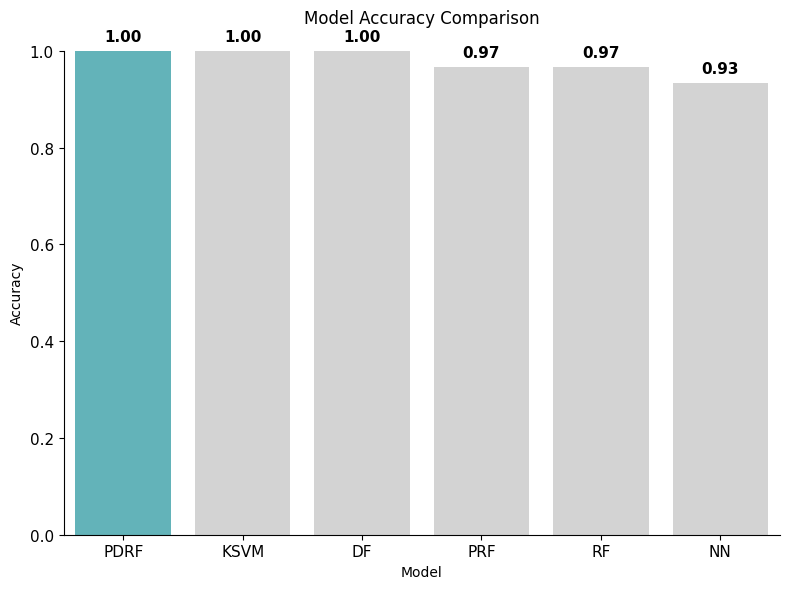

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data
data = {
    'Model': ['PRF', 'PDRF', 'NN', 'KSVM', 'DF','RF'],
    'Accuracy': [accuracy_PRF, accuracy_PDRF, accuracy_NN, accuracy_KSVM, accuracy_DF, accuracy_RF]
}

df = pd.DataFrame(data)

# Sort by Accuracy descending
df = df.sort_values('Accuracy', ascending=False)

# Define colors based on your request
def get_color(model):
    if model == 'PDRF':
        return '#55bfc7'
    elif model in ['PRF', 'DF']:
        return 'lightgray'
    else:
        return 'lightgray'

colors = df['Model'].apply(get_color)

plt.figure(figsize=(8,6))
ax = sns.barplot(x='Model', y='Accuracy', data=df, palette=colors)

# Remove top and right spines
sns.despine()

# Add space between title and plot
plt.title('Model Accuracy Comparison', pad=20)

# Set labels and limits
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Model')

# Set tick font size
ax.tick_params(axis='both', labelsize=11)

# Add accuracy values on top of each bar, bold
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold', color='black',
                xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()



#### Saving results

In [19]:
import os
from pathlib import Path

# 1. Extract filename base: last part after `/`, before `.`, remove "tra" if present
filename = Path(file_path).name  # 'my_dataset_tra.csv'
basename = filename.rsplit('.', 1)[0].replace('tra', '')  # 'my_dataset_'

# 2. Create output folder one level up
output_dir = Path(file_path).parent.parent / 'accuracy_scores'
output_dir.mkdir(parents=True, exist_ok=True)

# 3. Save the dataframe
output_path = output_dir / f'{basename}.csv'
df.to_csv(output_path, index=False)

print(f"Accuracy data saved to: {output_path}")


Accuracy data saved to: ../accuracy_scores/iris.csv
